In [1]:
library("igraph")


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



In [2]:
network <- read.graph("facebook_combined.txt", format="edgelist", directed=FALSE)

In [3]:
coreNodes <- (which(neighborhood.size(network, 1, nodes=V(network))>200))

In [4]:
print(length(coreNodes))

[1] 41


In [5]:
aveCoreDeg <- mean(degree(network, v=V(network)[coreNodes]))
print(aveCoreDeg)

[1] 277.439


id: 1 
   fast_greedy: 0.4131014 
   edge_betweenness: 0.3533022 


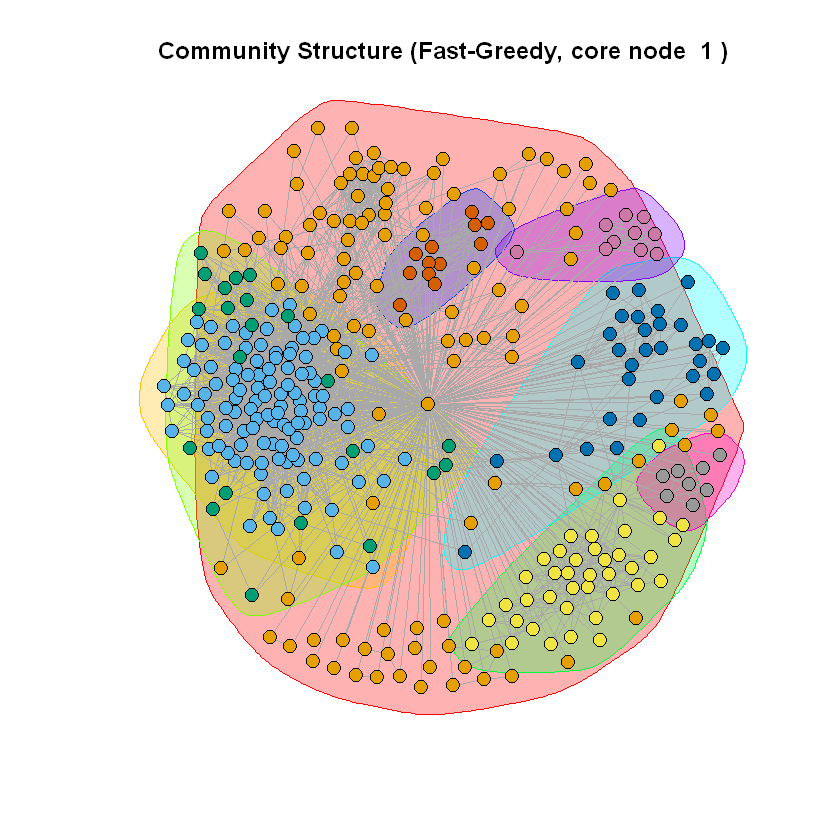

   infomap: 0.3941254 


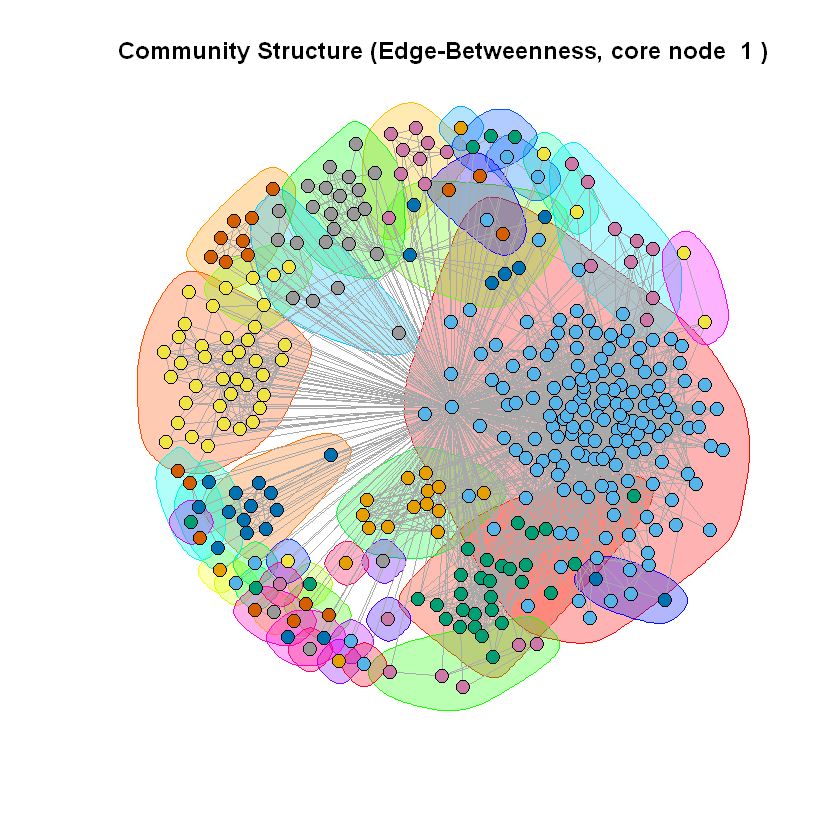


id: 108 
   fast_greedy: 0.4359294 


In [ ]:
#need to redo 
ids <- c(1, 108, 349, 484, 1087)
pnetworks <- make_ego_graph(network, 1, nodes=V(network)[ids])

for (i in 1:5) {
    cat("id:", ids[i], "\n")
    
    # 1 Fast-Greedy
    fc <- cluster_fast_greedy(pnetworks[[i]])
    cat("  ", "fast_greedy:", modularity(fc), "\n")
    # plot community structure
    fc_node_color <- fc$membership 
    plot(pnetworks[[i]], mark.groups=groups(fc), edge.arrow.size=.5, 
         vertex.color=fc_node_color, vertex.size=5, vertex.label="", 
    main=paste("Community Structure (Fast-Greedy, core node ",ids[i],")",collapse=""))
    
    # 2 Edge-Betweenness
    ec <- cluster_edge_betweenness(pnetworks[[i]])
    cat("  ", "edge_betweenness:", modularity(ec), "\n")
    # plot community structure
    ec_node_color <- ec$membership + 1
    plot(pnetworks[[i]], mark.groups=groups(ec), edge.arrow.size=.5, 
     vertex.color=ec_node_color, vertex.size=5, vertex.label="", 
    main=paste("Community Structure (Edge-Betweenness, core node ",ids[i],")",collapse=""))
    
    # 3 Infomap
    ic <- cluster_infomap(pnetworks[[i]])
    cat("  ", "infomap:", modularity(ic), "\n")
    # plot community structure
    ic_node_color <- ic$membership + 1
    plot(pnetworks[[i]], mark.groups=groups(ic), edge.arrow.size=.5, 
     vertex.color=ic_node_color, vertex.size=5, vertex.label="", 
    main=paste("Community Structure (Infomap, core node ",ids[i],")",collapse=""))
    cat("\n")
}

In [ ]:
ids <- c(1, 108, 349, 484, 1087)

for (i in 1:5) {
    cat("id:", ids[i], "\n")
    subgraph <- induced_subgraph(network, neighbors(network, ids[i]))
    
    # 1 Fast-Greedy
    fc <- cluster_fast_greedy(subgraph)
    cat("  ", "fast_greedy:", modularity(fc), "\n")
    # plot community structure
    fc_node_color <- fc$membership + 1
    plot(subgraph, mark.groups=groups(fc), edge.arrow.size=.5, 
         vertex.color=fc_node_color, vertex.size=5, vertex.label="", 
    main=paste("Community Structure (Fast-Greedy, Removed core node ",ids[i],")",collapse=""))
    
    # 2 Edge-Betweenness
    ec <- cluster_edge_betweenness(subgraph)
    cat("  ", "edge_betweenness:", modularity(ec), "\n")
    # plot community structure
    ec_node_color <- ec$membership + 1
    plot(subgraph, mark.groups=groups(ec), edge.arrow.size=.5, 
     vertex.color=ec_node_color, vertex.size=5, vertex.label="", 
    main=paste("Community Structure (Edge-Betweenness, Removed core node ",ids[i],")",collapse=""))
    
    # 3 Infomap
    ic <- cluster_infomap(subgraph)
    cat("  ", "infomap:", modularity(ic), "\n")
    # plot community structure
    ic_node_color <- ic$membership + 1
    plot(subgraph, mark.groups=groups(ic), edge.arrow.size=.5, 
     vertex.color=ic_node_color, vertex.size=5, vertex.label="", 
    main=paste("Community Structure (Infomap, Removed core node ",ids[i],")",collapse=""))
    cat("\n")
}

In [ ]:
core_nodes = c(1, 108, 349, 484, 1087)

mutual_friends <- function(graph, target, core) {
    neighbors_of_core_node <- neighbors(graph, core)
    neighbors_of_target <- neighbors(graph, target)
    
    #return(intersectiontarget_neighbors, core_neighbors)
    return(intersection(neighbors_of_core_node, neighbors_of_target))
}

embeddedness <- function(graph, target, core) {
    #return(mutual_friends(graph, core,target )))
    #return(mutual_friends(graph, target,core) ))
    
    return(length(mutual_friends(graph, target, core)))
}

dispersion <- function(graph, target, core) {
    
    #AllLabels <- V(graph)
    #target_label <- V(graph)[target]
    #core_label <- V(graph)[core]
    
    AllLabels <- V(graph)$label
    target_label <- V(graph)[target]$label
    core_label <- V(graph)[core]$label
    
    
    #labels <- vector()
    #for (label in AllLabels) {
    #    if (label != target_label & label != core_label) {
    #        labels <- label
    #    }
    #}
    
    
    labels <- c()
    for (label in AllLabels) {
        if (label != target_label & label != core_label) {
            labels <- c(labels, label)
        }
    }
    
    delete_graph <- delete_vertices(graph, c(core, target))
    V(delete_graph)$label <- sort(labels)
    
    mutual_friend <- mutual_friends(graph, target, core) 
    mutual_labels <- V(graph)[mutual_friend]$label
    vtoids <- c()
    for (id in V(delete_graph)) {
        for (label in mutual_labels) {
            if (V(delete_graph)[id]$label == label) {
                vtoids <- c(vtoids, id)
            }
        }
        
    }
    dist <- distances(delete_graph, v=vtoids, to=vtoids)
    dist[is.infinite(dist)] <- NA
    return(sum(dist, na.rm = TRUE)/2)
}

personalized_network <- function(core_node) {
    subgraph_nodes <- c(core_node, neighbors(network, core_node))
    personal_network <- induced_subgraph(network, c(core_node, neighbors(network, core_node)))
    V(personal_network)$label = sort(subgraph_nodes)
    return(personal_network)
}

count_distribution <- function(arr, distr, core_node) {
    arr <- sort(arr)
    df <- data.frame(value=c(NA), freq=c(NA))
    df <- df[-1, ]
    curValue <- arr[1]
    count <- 1
    for (i in 2:length(arr)) {
        if (arr[i] != curValue) {
            df[nrow(df)+1, ] <- c(curValue, count)
            curValue <- arr[i]
            count <- 1
        } else {
            count <- count + 1
        }
    }
    df[nrow(df)+1, ] <- c(curValue, count)
    return(df)
}

plot_embed_distribution <- function(df, core_node) {
    ggplot(df, aes(x=value, y=freq))+ 
    geom_bar(stat = "identity", fill="hotpink")+
    labs(title=paste("Distribution of Embeddedness (core node ",core_node,")",collapse=""), x="Embeddedness", y="Frequency")+
    theme(plot.title = element_text(hjust = 0.5))
}

plot_disp_distribution <- function(df, core_node) {
    plot(df, type="o", col="hotpink", main=paste("Distribution of Dispersion (core node ",core_node,")",collapse=""),
         xlab="Dispersion",ylab="Frequency")
}

embeds_list <- list()
for (core_node in core_nodes) {
    Origcore <- core_node
    
    personal_network <- personalized_network(core_node)
    core_node <- which(V(personal_network)$label == core_node)
    

    neighbors <- neighbors(personal_network, core_node, mode="total")
    embeds <- c()
    disps <- c()
    
    for (neighbor in neighbors) {
        cur_embed <- embeddedness(personal_network, neighbor, core_node)
        cur_disp <- dispersion(personal_network, neighbor, core_node)
        embeds <- c(embeds, cur_embed)
        disps <- c(disps, cur_disp)
    }

    embeds_df <- count_distribution(embeds)
    disps_df <- count_distribution(disps)
    embeds_list[[length(embeds_list)+1]] <- embeds_df

    plot_disp_distribution(disps_df, Origcore)
}

plot_embed_distribution(embeds_list[[1]], core_nodes[1])
plot_embed_distribution(embeds_list[[2]], core_nodes[2])
plot_embed_distribution(embeds_list[[3]], core_nodes[3])
plot_embed_distribution(embeds_list[[4]], core_nodes[4])
plot_embed_distribution(embeds_list[[5]], core_nodes[5])
